In [2]:
import nltk
import pandas as pd
import yfinance as yf
import numpy as np
import string
import datetime
import re
import math
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [3]:
#Reading the twitter data from the csv
tweets_df = pd.read_csv('Tweet.csv')

In [4]:
#Storing the twitter data onto a dataframe
aapl_test = tweets_df[tweets_df['body'].str.contains('AAPL')]

In [5]:
#date_transformation transforms the post_date column from epoch_timesteps to standard datetime 
def date_transformation(x):
    return datetime.datetime.fromtimestamp(x).date()

aapl_test['post_date'] = aapl_test['post_date'].apply(date_transformation)

<ipython-input-5-29c6665e6d02>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_test['post_date'] = aapl_test['post_date'].apply(date_transformation)


## VADER Sentiment Analysis

In [6]:
print("Start Time : {}".format(datetime.datetime.now()))
aapl_test['scores'] = aapl_test['body'].apply(lambda review: sid.polarity_scores(review))
aapl_test['compound']  = aapl_test['scores'].apply(lambda score_dict: score_dict['compound'])
aapl_test['sentiment'] = aapl_test['scores'].apply(lambda score_dict: 'pos' if score_dict['pos'] > score_dict['neg'] 
                                                   else ('neg' if score_dict['neg'] > score_dict['pos'] else 'neu'))
print("End Time : {}".format(datetime.datetime.now()))

Start Time : 2021-12-13 04:31:24.824245


<ipython-input-6-f00484d252af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_test['scores'] = aapl_test['body'].apply(lambda review: sid.polarity_scores(review))
<ipython-input-6-f00484d252af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_test['compound']  = aapl_test['scores'].apply(lambda score_dict: score_dict['compound'])


End Time : 2021-12-13 04:35:35.716171


<ipython-input-6-f00484d252af>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_test['sentiment'] = aapl_test['scores'].apply(lambda score_dict: 'pos' if score_dict['pos'] > score_dict['neg']


### Calculating the number of positive, negative and neutral tweets

In [7]:
positives = aapl_test['sentiment'][aapl_test.sentiment == 'pos']
negatives = aapl_test['sentiment'][aapl_test.sentiment == 'neg']
neutrals = aapl_test['sentiment'][aapl_test.sentiment == 'neu']
print('Number of positive tagged sentences are : {}'.format(len(positives)))
print('Number of negative tagged sentences are : {}'.format(len(negatives)))
print('Number of neutral tagged sentences are : {}'.format(len(neutrals)))
print('Total length of the data is : {}'.format(aapl_test.shape[0]))

Number of positive tagged sentences are : 526841
Number of negative tagged sentences are : 214720
Number of neutral tagged sentences are : 642798
Total length of the data is : 1384359


In [8]:
def word_count(sentence):
    return len(sentence.split())
    
aapl_test['word count'] = aapl_test['body'].apply(word_count)

<ipython-input-8-bf18716a5d16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_test['word count'] = aapl_test['body'].apply(word_count)


### Text Preprocessing for Sentiment Analysis

In [9]:
print("Start Time : {}".format(datetime.datetime.now()))

# text_preprocess_tweets method uses regular expressions to perform text preprocessing
def text_preprocess_tweets(tweet):
    # Removing HTML special entities
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Converting @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Removing tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Removing hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Removing hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Removing Punctuations 
    tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', tweet)
    # Removing words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Removing whitespace 
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Removing single space at the front of the tweet
    tweet = tweet.lstrip(' ') 
    # Removing characters beyond BMP(Basic Multilingual Plane) of Unicode
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

aapl_test['body'] = aapl_test['body'].apply(text_preprocess_tweets)

print("End Time : {}".format(datetime.datetime.now()))

Start Time : 2021-12-13 04:36:09.943712
End Time : 2021-12-13 04:36:38.637455


<ipython-input-9-3e53f439fadd>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_test['body'] = aapl_test['body'].apply(text_preprocess_tweets)


In [10]:
# tokenize_process removes any remaining punctuations and stopwords
def tokenize_process(raw_text):
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]

#aapl_test = aapl_test.copy()

print("Start Time : {}".format(datetime.datetime.now()))
aapl_test['tokens'] = aapl_test['body'].apply(tokenize_process) 
print("End Time : {}".format(datetime.datetime.now()))

Start Time : 2021-12-13 04:37:09.550435
End Time : 2021-12-13 05:13:26.090762


<ipython-input-10-56d44f13351a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_test['tokens'] = aapl_test['body'].apply(tokenize_process)


## Naive Bayes Classifier

In [12]:
# The feature to the Naive Bayes model are the tokens in the column 'body' of the dataframe
X = aapl_test['body']
# The labels are the sentiment tags
y = aapl_test['sentiment']

In [13]:
#splitting the dataset into training and test using the train_test_split method
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=7196)

#building the pipeline for grid search
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()),  
])
#using parameters fror the param grid
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }
print("Start Time : {}".format(datetime.datetime.now()))
# do 10-fold cross validation for each of the 8 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
mean_values = grid.cv_results_['mean_test_score']
std_values = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, std, param in zip(mean_values, std_values, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, std, param))
print("End Time : {}".format(datetime.datetime.now()))

Start Time : 2021-12-13 05:18:23.544586
Fitting 10 folds for each of 8 candidates, totalling 80 fits

Best Model: 0.866391 using {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.835430 Stdev:(0.000793) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.837950 Stdev:(0.000554) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.834316 Stdev:(0.000829) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.836105 Stdev:(0.000565) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.857149 Stdev:(0.000874) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.866391 Stdev:(0.001173) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.850059 Stdev:(0.000921) with: {'bow__ngram_range': (1, 2), 'classif

In [14]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )
# get predictions from best model above
y_preds = model_NB.predict(X_test)
print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

accuracy score:  0.8685630905255858


confusion matrix: 
 [[ 40748   4947   7755]
 [  4777 144299  11835]
 [  6877   9298 115554]]


              precision    recall  f1-score   support

         neg       0.78      0.76      0.77     53450
         neu       0.91      0.90      0.90    160911
         pos       0.86      0.88      0.87    131729

    accuracy                           0.87    346090
   macro avg       0.85      0.85      0.85    346090
weighted avg       0.87      0.87      0.87    346090



## Phase 3: Preparing the data for Multivariate Time series Analysis

In [15]:
positive_tweets = aapl_test[aapl_test['sentiment'] == 'pos']
negative_tweets = aapl_test[aapl_test['sentiment'] == 'neg']
neutral_tweets = aapl_test[aapl_test['sentiment'] == 'neu']

In [16]:
# tweets_distribution holds the total number of positive, negative and neutral tweets for each day from 2015-01-01 to 2019-12-31
tweets_distribution = aapl_test.groupby(['post_date', 'sentiment']).size()
tweets_distribution

post_date   sentiment
2015-01-01  neg           32
            neu          135
            pos          121
2015-01-02  neg          144
            neu          397
                        ... 
2019-12-30  neu          273
            pos          318
2019-12-31  neg           84
            neu          274
            pos          268
Length: 5478, dtype: int64

In [17]:
import yfinance as yf
apple_ticker = 'AAPL'

#importing the data corresponding to the ticker symbol from Yahoo finance
apple_ticker = yf.Ticker(apple_ticker)

#importing the historical stock prices for this ticker
hist = apple_ticker.history(start='2015-01-01', end='2020-01-01', interval='1d')

In [19]:
id_1 = pd.date_range('01-01-2015', '31-12-2019')
apple_test_date_fill = hist
apple_test_date_fill = apple_test_date_fill.reindex(id_1, fill_value=np.nan)
apple_test_date_fill.ffill(inplace=True)
apple_test_date_fill['b_score'] = 0.0
apple_test_date_fill['agreement_score'] = 0.0

In [20]:
apple_test_date_fill.reset_index(inplace=True)
apple_test_date_fill = apple_test_date_fill.rename(columns = {'index':'Date'})

In [21]:
positive_tweets_count = positive_tweets.groupby(['post_date']).size()
negative_tweets_count = negative_tweets.groupby(['post_date']).size()

for i in range(len(apple_test_date_fill)):
    numerator = 1+positive_tweets_count[i]
    denominator = 1+negative_tweets_count[i]
    num_2 = positive_tweets_count[i]-negative_tweets_count[i]
    den_2 = positive_tweets_count[i]+negative_tweets_count[i]
    apple_test_date_fill['b_score'][i] = np.log(numerator/denominator)
    apple_test_date_fill['agreement_score'][i] = 1-math.sqrt(1-(num_2/den_2))

<ipython-input-21-1b5ae5725c35>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_test_date_fill['b_score'][i] = np.log(numerator/denominator)
<ipython-input-21-1b5ae5725c35>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_test_date_fill['agreement_score'][i] = 1-math.sqrt(1-(num_2/den_2))


In [22]:
apple_test_date_fill['Close'][0] = 0
apple_test_date_fill['Open'][0] = 0
apple_test_date_fill['High'][0] = 0
apple_test_date_fill['Low'][0] = 0
apple_test_date_fill['Volume'][0] = 0
apple_test_date_fill['Dividends'][0] = 0
apple_test_date_fill['Stock Splits'][0] = 0

<ipython-input-22-335ae4a4bfed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_test_date_fill['Close'][0] = 0
<ipython-input-22-335ae4a4bfed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_test_date_fill['Open'][0] = 0
<ipython-input-22-335ae4a4bfed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_test_date_fill['High'][0] = 0
<ipython-input-22-335ae4a4bfed>:4: SettingWithCopyWarning: 
A value is trying to be set

In [23]:
apple_test_date_fill

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,b_score,agreement_score
0,2015-01-01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.307513,0.353238
1,2015-01-02,107.655779,107.704106,103.751215,105.664841,53204626.0,0.0,0.0,0.658056,0.174863
2,2015-01-03,107.655779,107.704106,103.751215,105.664841,53204626.0,0.0,0.0,1.849217,0.484746
3,2015-01-04,107.655779,107.704106,103.751215,105.664841,53204626.0,0.0,0.0,1.633535,0.433180
4,2015-01-05,104.659684,105.007616,101.876236,102.688072,64285491.0,0.0,0.0,0.960254,0.256857
...,...,...,...,...,...,...,...,...,...,...
1821,2019-12-27,287.369591,290.182882,284.408239,286.066589,36592936.0,0.0,0.0,1.258781,0.337526
1822,2019-12-28,287.369591,290.182882,284.408239,286.066589,36592936.0,0.0,0.0,1.240787,0.338112
1823,2019-12-29,287.369591,290.182882,284.408239,286.066589,36592936.0,0.0,0.0,1.466337,0.398583
1824,2019-12-30,285.730945,288.919345,281.545578,287.764404,36059614.0,0.0,0.0,1.287854,0.344539


In [33]:
#aapl_close_diff = hist['Close'].diff()
first_diffs = apple_test_date_fill['Close'][1:].diff()
#first_diffs = apple_test_date_fill.Close.values[1:] - apple_test_date_fill.Close.values[:-1]
first_diffs = np.append(first_diffs, apple_test_date_fill.Close.values[-1]) 
apple_test_date_fill['First_Difference'] = first_diffs

In [27]:
first_diffs_agreementscore = apple_test_date_fill.agreement_score.values[1:] - apple_test_date_fill.agreement_score.values[:-1]
first_diffs_agreementscore = np.append(first_diffs_agreementscore, apple_test_date_fill.agreement_score.values[-1]) 
apple_test_date_fill['agreement_score'] = first_diffs_agreementscore

In [28]:
#apple_test_date_fill = np.diff(apple_test_date_fill)[1:]

In [29]:
apple_test_date_fill

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,b_score,agreement_score,First_Difference
0,2015-01-01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.307513,-0.178375,NaN
1,2015-01-02,107.655779,107.704106,103.751215,105.664841,53204626.0,0.0,0.0,0.658056,0.309883,0.000000
2,2015-01-03,107.655779,107.704106,103.751215,105.664841,53204626.0,0.0,0.0,1.849217,-0.051566,0.000000
3,2015-01-04,107.655779,107.704106,103.751215,105.664841,53204626.0,0.0,0.0,1.633535,-0.176323,-2.976768
4,2015-01-05,104.659684,105.007616,101.876236,102.688072,64285491.0,0.0,0.0,0.960254,0.040987,0.009689
...,...,...,...,...,...,...,...,...,...,...,...
1821,2019-12-27,287.369591,290.182882,284.408239,286.066589,36592936.0,0.0,0.0,1.258781,0.000586,0.000000
1822,2019-12-28,287.369591,290.182882,284.408239,286.066589,36592936.0,0.0,0.0,1.240787,0.060471,0.000000
1823,2019-12-29,287.369591,290.182882,284.408239,286.066589,36592936.0,0.0,0.0,1.466337,-0.054045,1.697815
1824,2019-12-30,285.730945,288.919345,281.545578,287.764404,36059614.0,0.0,0.0,1.287854,-0.035388,2.102570


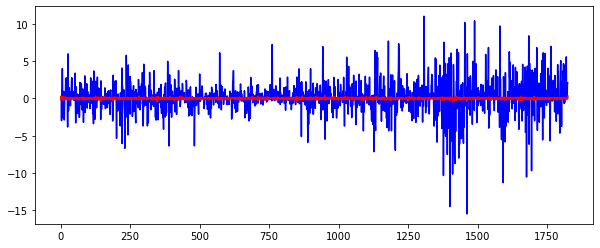

In [30]:
plt.figure(figsize=(10,4))
plt.plot(apple_test_date_fill['First_Difference'][1:-1], color='b')
plt.plot(apple_test_date_fill['agreement_score'], color='r')

In [31]:
split = round(len(apple_test_date_fill.First_Difference) / 2)
X1, X2 = apple_test_date_fill.First_Difference[0:split], apple_test_date_fill.First_Difference[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.038576, mean2=0.480709
variance1=1.887826, variance2=98.213383


## Granger Causality Test

In [34]:
from statsmodels.tsa.stattools import grangercausalitytests
ts_df = pd.DataFrame(columns=['t2', 't1'], data=zip(apple_test_date_fill['First_Difference'][1:-1],apple_test_date_fill['agreement_score'][1:-1]))

In [35]:
ts_df

,t2,t1
0,0.000000,0.309883
1,0.000000,-0.051566
2,-2.976768,-0.176323
3,0.009689,0.040987
4,1.440041,-0.021049
...,...,...
1819,-0.108612,0.035116
1820,0.000000,0.000586
1821,0.000000,0.060471
1822,1.697815,-0.054045


In [36]:
gc_res = grangercausalitytests(ts_df, 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2185  , p=0.2698  , df_denom=1820, df_num=1
ssr based chi2 test:   chi2=1.2205  , p=0.2693  , df=1
likelihood ratio test: chi2=1.2201  , p=0.2693  , df=1
parameter F test:         F=1.2185  , p=0.2698  , df_denom=1820, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5205  , p=0.5943  , df_denom=1817, df_num=2
ssr based chi2 test:   chi2=1.0438  , p=0.5934  , df=2
likelihood ratio test: chi2=1.0435  , p=0.5935  , df=2
parameter F test:         F=0.5205  , p=0.5943  , df_denom=1817, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4549  , p=0.7138  , df_denom=1814, df_num=3
ssr based chi2 test:   chi2=1.3700  , p=0.7126  , df=3
likelihood ratio test: chi2=1.3695  , p=0.7127  , df=3
parameter F test:         F=0.4549  , p=0.7138  , df_denom=1814, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7396  , p=0.

In [165]:
apple_test_date_fill.to_csv('../twitter_processed.CSV',index=False)